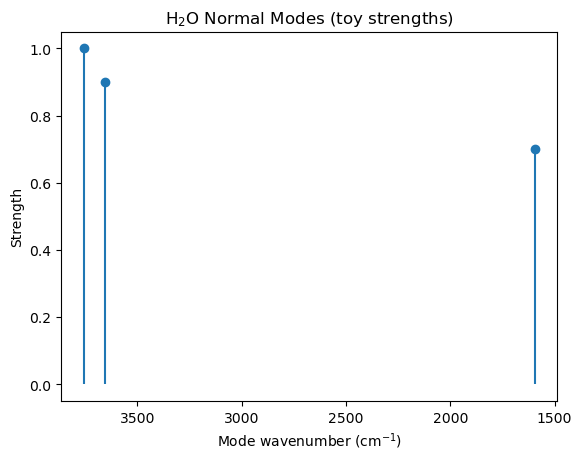

Created files:
water_modes_pad.wav
water_modes_sequence.wav
Mapped Hz (cm^-1 * 1): [1595. 3657. 3756.]


In [1]:
# Re-running the normal-mode sonification demo after a fresh kernel start.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import wave

SR = 44100

def save_wav_stereo(path, yL, yR, sr=SR):
    yL = np.clip(yL, -1, 1)
    yR = np.clip(yR, -1, 1)
    interleaved = np.empty((yL.size + yR.size,), dtype=np.int16)
    interleaved[0::2] = (yL * 32767).astype(np.int16)
    interleaved[1::2] = (yR * 32767).astype(np.int16)
    with wave.open(str(path), 'wb') as wf:
        wf.setnchannels(2)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(interleaved.tobytes())
    return str(path)

def envelope_adsr(n, sr=SR, A=0.01, D=0.05, S=0.7, R=0.2):
    attack = int(A*sr); decay = int(D*sr); release = int(R*sr)
    sustain_len = max(0, n - attack - decay - release)
    a = np.linspace(0, 1, max(1,attack), endpoint=False)
    d = np.linspace(1, S, max(1,decay), endpoint=False)
    s = np.full(sustain_len, S)
    r = np.linspace(S, 0, max(1,release), endpoint=True)
    env = np.concatenate([a,d,s,r])
    if env.size < n:
        env = np.pad(env, (0, n-env.size))
    return env[:n]

def lfo(length, rate_hz, depth=1.0, sr=SR, phase=0.0):
    t = np.arange(int(length*sr))/sr
    return depth*np.sin(2*np.pi*rate_hz*t + phase)

def pan_stereo(y, pan):  # -1 left, +1 right (equal-power panning)
    theta = (pan+1)*0.25*np.pi
    L = y*np.cos(theta)
    R = y*np.sin(theta)
    return L, R

def modal_synthesis_from_modes(
    modes_cm1, strengths=None, 
    duration=6.0, sr=SR,
    cm1_to_hz=1.0,
    global_adsr=(0.02,0.2,0.85,0.8),
    per_mode_decay=0.6,        # seconds, time-constant for exponential decay per mode
    vibrato_rate=5.5, vibrato_depth=0.002,
    tremolo_rate=3.5, tremolo_depth=0.1,
    stereo=True, rng_seed=7
):
    n = int(duration*sr)
    t = np.arange(n)/sr
    rng = np.random.default_rng(rng_seed)
    modes_cm1 = np.asarray(modes_cm1, dtype=float)
    if strengths is None:
        strengths = np.ones_like(modes_cm1)
    w = np.asarray(strengths, dtype=float)
    # normalize strengths with gentle compression
    w = w / (w.max() + 1e-9)
    w = np.sqrt(w)
    w = 0.98*w / (w.sum() + 1e-9)
    freqs = np.clip(modes_cm1 * cm1_to_hz, 20, sr//2 - 200)
    env = envelope_adsr(n, sr, *global_adsr)
    trem = 1.0 + tremolo_depth * lfo(duration, tremolo_rate, 1.0, sr, phase=rng.uniform(0,2*np.pi))
    yL = np.zeros(n, dtype=np.float32)
    yR = np.zeros(n, dtype=np.float32)
    for f, g in zip(freqs, w):
        vib = 1.0 + vibrato_depth * np.sin(2*np.pi*vibrato_rate*t + rng.uniform(0,2*np.pi))
        phase = 2*np.pi*np.cumsum((f*vib) / sr)
        # exponential decay per mode (independent from global ADSR)
        decay = np.exp(-t/np.maximum(1e-3, per_mode_decay))
        y = g * np.sin(phase) * decay
        if stereo:
            pan = rng.uniform(-1, 1)
            L, R = pan_stereo(y, pan)
        else:
            L = R = y
        yL += L.astype(np.float32)
        yR += R.astype(np.float32)
    yL *= env * trem
    yR *= env * trem
    # normalize
    peak = max(1e-9, np.max(np.abs([yL,yR])))
    yL = (0.95/peak)*yL
    yR = (0.95/peak)*yR
    return yL, yR, freqs

# Example: H2O approximate normal modes (cm^-1)
water_modes = np.array([1595.0, 3657.0, 3756.0])          # bend, sym stretch, asym stretch
water_strengths = np.array([0.7, 0.9, 1.0])

# 1) Sustained chord / modal pad
L1, R1, freqs_hz = modal_synthesis_from_modes(
    water_modes, water_strengths,
    duration=6.0, cm1_to_hz=1.0, per_mode_decay=3.0
)
path_pad = Path("water_modes_pad.wav")
save_wav_stereo(path_pad, L1, R1, SR)

# 2) Sequenced excitation (one mode at a time)
piecesL, piecesR = [], []
for m, s in zip(water_modes, water_strengths):
    L, R, _ = modal_synthesis_from_modes([m], [s], duration=2.0, cm1_to_hz=1.0, per_mode_decay=1.0)
    piecesL.append(L); piecesR.append(R)
L2 = np.concatenate(piecesL); R2 = np.concatenate(piecesR)
path_seq = Path("water_modes_sequence.wav")
save_wav_stereo(path_seq, L2, R2, SR)

# Plot the "mode spectrum"
plt.figure()
plt.stem(water_modes, water_strengths, basefmt=" ")
plt.gca().invert_xaxis()
plt.xlabel("Mode wavenumber (cm$^{-1}$)")
plt.ylabel("Strength")
plt.title("H$_2$O Normal Modes (toy strengths)")
plt.show()

print("Created files:")
print(str(path_pad))
print(str(path_seq))
print("Mapped Hz (cm^-1 * 1):", freqs_hz)


In [2]:
from IPython.display import Audio



In [20]:
Audio(filename="water_modes_pad.wav", rate=44100//2)

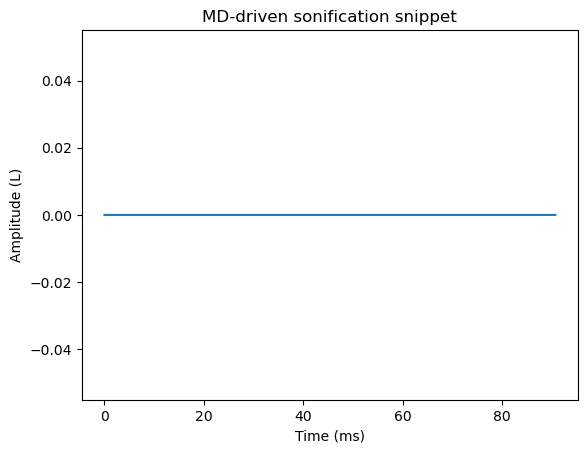

WAV: md_realtimeish_water.wav
Duration (s): 1.4960997732426304


In [4]:
# Re-run after a fresh start: MD→Audio scaffolding
import numpy as np
from pathlib import Path
import wave
import matplotlib.pyplot as plt

SR = 44100
BLOCK = 1024

def save_wav_stereo(path, yL, yR, sr=SR):
    yL = np.clip(yL, -1, 1)
    yR = np.clip(yR, -1, 1)
    interleaved = np.empty((yL.size + yR.size,), dtype=np.int16)
    interleaved[0::2] = (yL * 32767).astype(np.int16)
    interleaved[1::2] = (yR * 32767).astype(np.int16)
    with wave.open(str(path), 'wb') as wf:
        wf.setnchannels(2)
        wf.setsampwidth(2)
        wf.setframerate(sr)
        wf.writeframes(interleaved.tobytes())
    return str(path)

def hz_from_cm1(cm1, mode="center", ref_cm1=1650.0, ref_hz=220.0):
    cm1 = np.asarray(cm1, dtype=float)
    if mode in ("linear","center"):
        scale = ref_hz / ref_cm1
        return cm1 * scale
    elif mode == "logwrap":
        lo, hi = 120.0, 2500.0
        cmin, cmax = max(1.0, cm1.min()), cm1.max()
        x = (np.log(cm1) - np.log(cmin)) / (np.log(cmax) - np.log(cmin) + 1e-12)
        return lo * (hi/lo)**x
    else:
        raise ValueError("Unknown mapping mode.")

class ModalBank:
    def __init__(self, modes_cm1, strengths=None, map_mode="center", ref_pair=(1650.0, 220.0),
                 damping_s=1.5, vibrato_depth=0.0, vibrato_rate=5.0, rng_seed=0):
        self.rng = np.random.default_rng(rng_seed)
        self.modes_cm1 = np.asarray(modes_cm1, float)
        self.freqs_hz = hz_from_cm1(self.modes_cm1, mode=map_mode,
                                    ref_cm1=ref_pair[0], ref_hz=ref_pair[1])
        if strengths is None:
            strengths = np.ones_like(self.modes_cm1)
        w = np.asarray(strengths, float)
        w = np.sqrt(w / (w.max() + 1e-12))
        self.gains = 0.98 * w / (w.sum() + 1e-12)
        self.vib_depth = float(vibrato_depth)
        self.vib_rate = float(vibrato_rate)
        self.phase = np.zeros_like(self.freqs_hz, dtype=float)
        self.pan = self.rng.uniform(-1, 1, size=self.freqs_hz.shape)
        self.decay_tau = float(damping_s)
        self.env = 0.0
        self.env_target = 0.0
        self.env_decay = 0.9995
        self.env_release = 0.9998
        self.Q = np.zeros_like(self.freqs_hz)
        self.Qdot = np.zeros_like(self.freqs_hz)

    def set_Q(self, Q, Qdot=None):
        Q = np.asarray(Q, float)
        if Q.shape != self.Q.shape:
            raise ValueError("Q shape mismatch")
        self.Q = Q
        if Qdot is not None:
            self.Qdot = np.asarray(Qdot, float)

    def strike(self, amt=1.0):
        self.env_target = min(1.0, self.env_target + amt)

    def _advance_env(self, n):
        env = np.empty(n, float); e = self.env; target = self.env_target
        for i in range(n):
            coeff = self.env_release if target < e else self.env_decay
            e = e * coeff + (1 - coeff) * target
            target *= 0.999
            env[i] = e
        self.env = e; self.env_target = target
        return env

    def render_block(self, sr=SR, block=BLOCK, dipole_scalar=0.0):
        t = (np.arange(block)/sr)
        vib = 1.0 + self.vib_depth * np.sin(2*np.pi*self.vib_rate*t + self.rng.uniform(0,2*np.pi))
        f_inst = self.freqs_hz * (1.0 + 0.02*self.Q)
        decay = np.exp(-np.arange(block)/sr / max(1e-3, self.decay_tau))
        yL = np.zeros(block, float); yR = np.zeros(block, float)
        for k, (f, g, p) in enumerate(zip(f_inst, self.gains, self.pan)):
            phase_inc = 2*np.pi * (f * vib) / sr
            phi = np.cumsum(phase_inc)
            y = np.sin(phi) * (g * (0.3 + 0.7*np.clip(np.abs(self.Q[k]) + 0.2*np.abs(self.Qdot[k]), 0, 1)))
            y *= decay
            theta = (p+1)*0.25*np.pi
            yL += y*np.cos(theta); yR += y*np.sin(theta)
        if dipole_scalar != 0.0:
            noise = np.random.standard_normal(block).astype(float)
            noise = np.convolve(noise, [1, -0.97], mode='same')
            yL += 0.05 * dipole_scalar * noise
            yR += 0.05 * dipole_scalar * noise
        env = self._advance_env(block)
        yL *= env; yR *= env
        peak = max(1e-9, np.max(np.abs([yL,yR])))
        if peak > 0.98:
            yL *= 0.98/peak; yR *= 0.98/peak
        return yL.astype(np.float32), yR.astype(np.float32)

def synthetic_md_generator(num_steps=3000, num_modes=3, dt_fs=0.5):
    rng = np.random.default_rng(42)
    Q = np.zeros(num_modes, float)
    Qdot = np.zeros(num_modes, float)
    mu = np.array([0.0, 0.0, 1.0])
    for i in range(num_steps):
        t_fs = i*dt_fs
        Qdot += -0.02*Q + 0.01*rng.standard_normal(num_modes)
        Q += Qdot
        if i % 400 == 0:
            Q += rng.normal(0.8, 0.2, size=num_modes)
        mu = 0.99*mu + 0.01*np.array([Q[0], Q[1], 1.0+0.3*Q[2]])
        T = 300 + 50*rng.standard_normal()
        yield {"step": i, "t_fs": t_fs, "Q": Q.copy(), "Qdot": Qdot.copy(), "mu": mu.copy(), "T": T}

def render_from_md(modal_bank, md_iter, out_path, sr=SR, block=BLOCK,
                   time_scale_s_per_fs=1e-3,
                   dipole_to_brightness=lambda mu: float(np.linalg.norm(mu))/3.0):
    bufL = []; bufR = []
    first = True; prev_tfs = None
    for packet in md_iter:
        tfs = packet["t_fs"]
        if first:
            prev_tfs = tfs; first = False
        dt_fs = max(1e-9, tfs - prev_tfs); prev_tfs = tfs
        samples_needed = int(round(dt_fs * time_scale_s_per_fs * sr))
        modal_bank.set_Q(packet["Q"], packet["Qdot"])
        if np.linalg.norm(packet["Qdot"]) > 0.7:
            modal_bank.strike(amt=0.5)
        remaining = samples_needed
        while remaining > 0:
            n = min(block, remaining)
            yL, yR = modal_bank.render_block(sr=sr, block=n,
                                             dipole_scalar=dipole_to_brightness(packet["mu"]))
            bufL.append(yL); bufR.append(yR)
            remaining -= n
    yL = np.concatenate(bufL) if bufL else np.zeros(0, dtype=np.float32)
    yR = np.concatenate(bufR) if bufR else np.zeros(0, dtype=np.float32)
    save_wav_stereo(out_path, yL, yR, sr)
    return out_path, yL, yR

# --- Demo run ---
modes_cm1 = np.array([1595.0, 3657.0, 3756.0])
strengths = np.array([0.7, 0.9, 1.0])

bank = ModalBank(modes_cm1, strengths, map_mode="center", ref_pair=(1650.0, 220.0),
                 damping_s=2.5, vibrato_depth=0.001, vibrato_rate=5.0)

md = synthetic_md_generator(num_steps=3000, num_modes=3, dt_fs=0.5)

out_path = Path("md_realtimeish_water.wav")
p, yL, yR = render_from_md(bank, md, out_path, time_scale_s_per_fs=1e-3)

# Visualization: waveform snippet
import matplotlib.pyplot as plt
plt.figure()
N = min(4000, yL.size)
plt.plot(np.arange(N)/SR*1000, yL[:N])
plt.xlabel("Time (ms)"); plt.ylabel("Amplitude (L)")
plt.title("MD-driven sonification snippet")
plt.show()

print("WAV:", str(p))
print("Duration (s):", yL.size/SR)


In [50]:
Audio(filename="md_realtimeish_water.wav", rate=44100/2)

In [6]:
path_md_ir = "/home/ericb/mmml/examples/co2/dcmnet_physnet_train/md_ir_long/md_ir_spectrum.npz"
data_md_ir =  np.load(path_md_ir)

In [7]:
list(data_md_ir.keys())

['frequencies',
 'intensities',
 'intensity_physnet',
 'intensity_dcmnet',
 'autocorrelation',
 'times']

In [8]:
import pandas as pd


In [ ]:
# plt.scatter(data_md_ir["fre"], )

In [10]:
data_md_ir["autocorrelation"]

array([ 0.00845833,  0.00842295,  0.00832217, ..., -0.00413571,
       -0.00419365, -0.00414181], shape=(500000,))

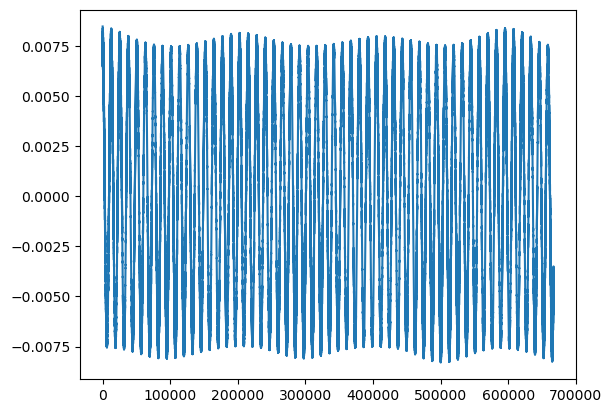

In [11]:
plt.plot(data_md_ir["frequencies"][1::2], data_md_ir["autocorrelation"], alpha=1)

In [47]:
NSKIP = 200
freqs = data_md_ir["frequencies"][NSKIP:]
intPN = (1 - freqs/freqs.max()) * data_md_ir["intensity_physnet"][NSKIP:]

In [48]:
data_md_ir["frequencies"][10:]
data_md_ir["intensity_physnet"][10:]

array([1.35817612e-09, 1.99967441e-09, 2.34016624e-09, ...,
       1.68290136e-24, 2.32706218e-24, 2.57737694e-24], shape=(999991,))

/tmp/ipykernel_1027/2582386765.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(freqs, np.log(intPN), alpha=1)


(500.0, 4000.0)

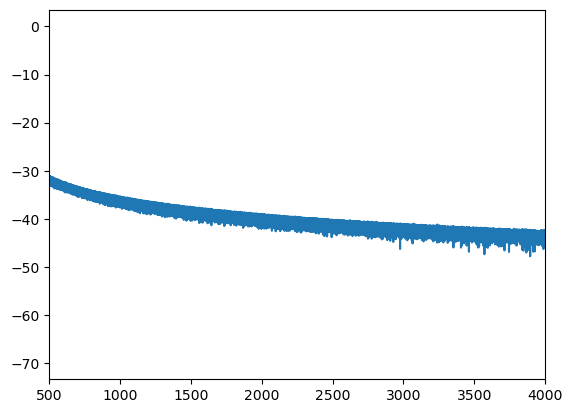

In [49]:

plt.plot(freqs, np.log(intPN), alpha=1)
plt.xlim(500, 4000)
# plt.ylim(0, 0.00001)

In [42]:
intPN

array([7.89567404e-17, 5.69795901e-17, 6.44572858e-18, ...,
       3.36580272e-30, 2.32706218e-30, 0.00000000e+00], shape=(998001,))

In [14]:
# # === Set this to your real file ===
# NPZ_PATH = path_md_ir

# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path
# import wave
# from IPython.display import Audio, display

# SR = 44100
# seconds_per_time_unit = 1e-3  # if times are fs: 1 fs -> 1 ms of audio
# ref_pair = (1650.0, 220.0)    # map 1650 cm^-1 to 220 Hz (A3)
# use_intensity_key = "intensities"  # or "intensity_physnet", "intensity_dcmnet"

# # --- helpers ---
# def save_wav_int16_stereo(path, yL, yR, sr=SR):
#     yL = np.clip(yL, -1.0, 1.0).astype(np.float32)
#     yR = np.clip(yR, -1.0, 1.0).astype(np.float32)
#     interleaved = np.empty(yL.size + yR.size, dtype=np.int16)
#     interleaved[0::2] = (yL * 32767).astype(np.int16)
#     interleaved[1::2] = (yR * 32767).astype(np.int16)
#     with wave.open(str(path), 'wb') as wf:
#         wf.setnchannels(2); wf.setsampwidth(2); wf.setframerate(sr)
#         wf.writeframes(interleaved.tobytes())
#     return str(path)

# def save_wav_int16_mono(path, y, sr=SR):
#     y = np.clip(y, -1.0, 1.0).astype(np.float32)
#     with wave.open(str(path), 'wb') as wf:
#         wf.setnchannels(1); wf.setsampwidth(2); wf.setframerate(sr)
#         wf.writeframes((y * 32767).astype(np.int16).tobytes())
#     return str(path)

# def hz_from_cm1(cm1, ref_cm1=1650.0, ref_hz=220.0):
#     return np.asarray(cm1, float) * (ref_hz / ref_cm1)

# def smooth_ma(x, win):
#     if win <= 1: return x
#     k = np.ones(win, dtype=float) / float(win)
#     return np.convolve(x, k, mode='same')

# def additive_modal_synth(freqs_hz, gains, length_s, sr=SR, envelope=None, stereo=True, pan_seed=7):
#     n = int(round(length_s * sr))
#     t = np.arange(n) / sr
#     yL = np.zeros(n, dtype=np.float64)
#     yR = np.zeros(n, dtype=np.float64)
#     rng = np.random.default_rng(pan_seed)
#     pans = rng.uniform(-1, 1, size=len(freqs_hz)) if stereo else np.zeros(len(freqs_hz))
#     for f, g, p in zip(freqs_hz, gains, pans):
#         if f <= 0: 
#             continue
#         s = np.sin(2*np.pi*f*t)
#         if envelope is not None:
#             s = s * envelope
#         theta = (p+1) * 0.25 * np.pi
#         yL += g * s * np.cos(theta)
#         yR += g * s * np.sin(theta)
#     peak = max(1e-12, np.max(np.abs([yL, yR])))
#     yL = 0.95 * yL / peak; yR = 0.95 * yR / peak
#     return yL.astype(np.float32), yR.astype(np.float32)

# # --- load ---
# data = np.load(NPZ_PATH, allow_pickle=True)
# print("NPZ keys:", list(data.keys()))
# freqs_cm1 = np.asarray(data["frequencies"], float).ravel()
# inten = np.asarray(data[use_intensity_key], float).ravel()
# autoc = np.asarray(data["autocorrelation"], float).ravel()
# times = np.asarray(data["times"], float).ravel()

# # --- IR → instrument ---
# w = inten / (np.max(inten) + 1e-12)
# w = np.sqrt(w)
# gains = 0.98 * w / (np.sum(w) + 1e-12)
# freqs_hz = hz_from_cm1(freqs_cm1, ref_cm1=ref_pair[0], ref_hz=ref_pair[1])

# # --- autocorr → brightness envelope ---
# t_audio = times * seconds_per_time_unit
# T = float(t_audio[-1] - t_audio[0])
# if T <= 0:
#     raise ValueError("Non-increasing 'times' array.")
# env_raw = np.abs(autoc)
# win = max(3, int(round(0.01 * env_raw.size)))
# env_s = smooth_ma(env_raw, win)
# env_s = env_s / (np.max(env_s) + 1e-12)

# ta = np.linspace(t_audio[0], t_audio[-1], int(round(T*SR)))
# env_audio = np.interp(ta, t_audio, env_s).astype(np.float32)

# # fade in/out a touch
# atk = min(int(0.02*SR), max(1, env_audio.size//100))
# rel = atk
# env_audio[:atk] *= np.linspace(0, 1, atk, endpoint=False)
# env_audio[-rel:] *= np.linspace(1, 0, rel, endpoint=True)

# # --- synth & save ---
# yL, yR = additive_modal_synth(freqs_hz, gains, length_s=T, sr=SR, envelope=env_audio, stereo=True)
# modal_path = Path("modal_from_ir_autocorr.wav")
# save_wav_int16_stereo(modal_path, yL, yR, SR)

# env_path = Path("dipole_autocorr_envelope.wav")
# save_wav_int16_mono(env_path, (2*env_audio - 1.0)*0.4, SR)

# # --- visuals ---
# plt.figure(figsize=(6.2, 3))
# plt.plot(freqs_cm1, inten, marker='o', lw=1)
# plt.gca().invert_xaxis()
# plt.xlabel("Wavenumber (cm$^{-1}$)"); plt.ylabel("Intensity")
# plt.title("IR intensities used for modal gains")
# plt.tight_layout(); plt.show()

# plt.figure(figsize=(6.2, 3))
# plt.plot(times, autoc, lw=1, alpha=0.75, label="autocorr")
# plt.plot(times, env_s*(np.max(autoc)+1e-12), lw=2, label="smoothed (scaled)")
# plt.xlabel("Time (original units)"); plt.ylabel("Autocorr")
# plt.title("Dipole autocorrelation and smoothed envelope")
# plt.legend(); plt.tight_layout(); plt.show()

# display(Audio(filename=str(modal_path)))
# display(Audio(filename=str(env_path)))

# print("WAVs:")
# print("  Instrument:", modal_path)
# print("  Envelope:", env_path)


In [15]:
# JAX modal synth core: vectorized, no Python loops
import jax
import jax.numpy as jnp
from jax import jit, lax

def prep_modal_bank_jax(freqs_hz, gains, pan, sr=44100.0):
    """Precompute constants for a stable complex-oscillator recurrence."""
    freqs = jnp.asarray(freqs_hz, dtype=jnp.float32)  # [M]
    gains = jnp.asarray(gains, dtype=jnp.float32)     # [M]
    pan   = jnp.asarray(pan, dtype=jnp.float32)       # [-1..1], [M]
    # complex step per sample
    w = 2*jnp.pi*freqs/sr                              # [M]
    step = jnp.exp(1j*w)                               # [M] complex
    # equal-power pan
    theta = (pan+1.0)*0.25*jnp.pi
    panL = jnp.cos(theta); panR = jnp.sin(theta)       # [M]
    return step, gains, panL, panR

@jit
def render_block_jax(state, step, gains, panL, panR, env_block, decay_tau, vib_rate=0.0, vib_depth=0.0, sr=44100.0):
    """
    state: complex oscillators z (shape [M]) at block start
    step:  complex step per sample e^{i*ωΔt} for each mode [M]
    gains: per-mode scalar [M]
    panL, panR: per-mode equal-power pans [M]
    env_block: amplitude envelope for this audio block [N]
    decay_tau: exponential decay time-constant in seconds (scalar)
    returns: (new_state_z, yL, yR)
    """
    M = state.shape[0]
    N = env_block.shape[0]
    decay = jnp.exp(-1.0/(decay_tau*sr))

    def body(carry, i):
        z = carry  # [M] complex
        # optional vibrato (vectorized): z_next = z * (step * e^{i*Δφ_i})
        if vib_depth > 0:
            phi = 2*jnp.pi*(vib_rate/sr)*i
            vib = jnp.exp(1j * (vib_depth * jnp.sin(phi)))
            z = z * (step * vib)
        else:
            z = z * step
        # signal = imag(z)
        s = jnp.imag(z) * gains * (decay**i) * env_block[i]  # [M]
        yL_i = jnp.sum(s * panL)
        yR_i = jnp.sum(s * panR)
        return z, (yL_i, yR_i)

    z0 = state
    zN, (yL, yR) = lax.scan(body, z0, jnp.arange(N))
    yL = jnp.asarray(yL, dtype=jnp.float32)
    yR = jnp.asarray(yR, dtype=jnp.float32)
    # simple peak limiter per block
    peak = jnp.maximum(jnp.max(jnp.abs(jnp.stack([yL,yR]))), 1e-7)
    gain = jnp.minimum(0.98/peak, 1.0)
    return zN, yL*gain, yR*gain


In [56]:
import numpy as np

def jax_modal_render(freqs_hz, gains, pan, envelope, sr=44100, block=2048, decay_tau=2.0):
    step, gains_j, panL, panR = prep_modal_bank_jax(freqs_hz, gains, pan, sr=sr)
    z = jnp.ones_like(step, dtype=jnp.complex64)  # initial phases
    yL_all = []; yR_all = []
    # Warmup JIT on a single block for consistent speed
    env_warm = jnp.ones((block,), dtype=jnp.float32)
    z, _, _ = render_block_jax(z, step, gains_j, panL, panR, env_warm, decay_tau)

    n = len(envelope); i = 0
    while i < n:
        env_block = jnp.asarray(envelope[i:i+block], dtype=jnp.float32)
        z, yL, yR = render_block_jax(z, step, gains_j, panL, panR, env_block, decay_tau)
        yL_all.append(np.array(yL)); yR_all.append(np.array(yR))
        i += block
    return np.concatenate(yL_all), np.concatenate(yR_all)


In [57]:
SR = 44100
seconds_per_time_unit = 1e-3           # if 'times' are in fs: 1 fs -> 1 ms audio
ref_cm1, ref_hz = 1650.0, 220.0 / 4.0        # map 1650 cm^-1 -> 220 Hz (A3)
intensity_key = "intensities"          # or "intensity_physnet" / "intensity_dcmnet"
max_partials = 96                      # speed/tone tradeoff
block = 4096                           # larger = faster, smaller = lower latency
decay_tau = 2.0                        # modal decay time (s)

# ---------- LOAD ----------
data = np.load(NPZ_PATH, allow_pickle=True)
freqs_cm1 = np.asarray(data["frequencies"], float).ravel()
inten = np.asarray(data[intensity_key], float).ravel()
autoc = np.asarray(data["autocorrelation"], float).ravel()
times = np.asarray(data["times"], float).ravel()

# ---------- PICK TOP PARTIALS ----------
# gentle compression so very strong lines don't dominate
w = inten / (inten.max() + 1e-12)
w = np.sqrt(w)
idx = np.argsort(w)[::-1][:max_partials]
freqs_cm1 = freqs_cm1[idx]
w = w[idx]

# normalize gains
gains = 0.98 * (w / (w.sum() + 1e-12))

# map cm^-1 -> Hz (center mapping)
freqs_hz = freqs_cm1 * (ref_hz / ref_cm1)

# ---------- ENVELOPE FROM AUTOCORR ----------
# times → audio seconds (your choice of scaling)
t_audio = times * seconds_per_time_unit
T = float(t_audio[-1] - t_audio[0])
n_samples = int(round(T * SR))
ta = np.linspace(t_audio[0], t_audio[-1], n_samples)

# smooth |autoc| (simple moving average, JAX-free for simplicity)
env_raw = np.abs(autoc)
win = max(3, int(0.01 * env_raw.size))
k = np.ones(win) / win
env_s = np.convolve(env_raw, k, mode="same")
env_s /= (env_s.max() + 1e-12)

# resample envelope to audio grid
envelope = np.interp(ta, t_audio, env_s).astype(np.float32)

# small fade in/out
fade = max(1, int(0.02 * SR))
if envelope.size >= 2*fade:
    envelope[:fade] *= np.linspace(0, 1, fade, endpoint=False)
    envelope[-fade:] *= np.linspace(1, 0, fade, endpoint=True)

# ---------- PAN SETUP ----------
M = len(freqs_hz)
pan = np.linspace(-0.85, 0.85, M).astype(np.float32)

# ---------- JAX RENDER ----------
yL, yR = jax_modal_render(freqs_hz, gains, pan, envelope, sr=SR, block=block, decay_tau=decay_tau)

# ---------- SAVE + PLAY ----------
def save_wav_stereo(path, yL, yR, sr=SR):
    yL = np.clip(yL, -1, 1); yR = np.clip(yR, -1, 1)
    inter = np.empty(yL.size + yR.size, dtype=np.int16)
    inter[0::2] = (yL * 32767).astype(np.int16)
    inter[1::2] = (yR * 32767).astype(np.int16)
    with wave.open(str(path), 'wb') as wf:
        wf.setnchannels(2); wf.setsampwidth(2); wf.setframerate(sr)
        wf.writeframes(inter.tobytes())
    return str(path)

out_path = Path("jax_modal_from_autocorr.wav")
save_wav_stereo(out_path, yL, yR, SR)
display(Audio(filename=str(out_path)))
print("Wrote:", out_path, "duration (s):", len(yL)/SR)

Wrote: jax_modal_from_autocorr.wav duration (s): 12.499977324263039


In [58]:
!pip install cmaps
import cmaps

/home/ericb/anaconda3/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [65]:
# test = np.stack([yL, yR], axis=0)
test = yL
test = test.reshape(431, 1279)
test.shape

(431, 1279)

Saved: test_growth.gif


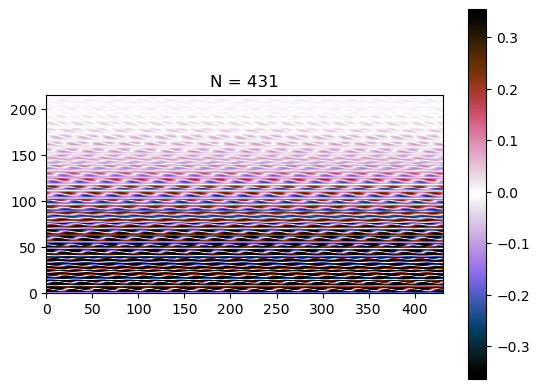

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from cmap import Colormap

# ----- config -----
step = 10                 # grow N by this step each frame
fps = 60                  # GIF framerate
out_gif = "test_growth.gif"
cm = Colormap('cmasher:emergency').to_matplotlib()

# test must already exist: 2D array with shape (M, M) or at least square-like
M = min(test.shape[0], test.shape[1])   # safest square crop
Nmax = M                                # or set e.g. Nmax = min(M, 2000) to limit size/speed

# fixed buffer (constant shape) to avoid axis rescale
buf = np.full((Nmax, Nmax), np.nan, dtype=float)

# fixed color normalization (keeps colors consistent across frames)
# use percentiles for robust limits; adjust as needed
vmin, vmax = np.nanpercentile(test[:Nmax, :Nmax], [2, 98])

fig, ax = plt.subplots()
im = ax.imshow(buf.T, origin='upper', cmap=cm, vmin=vmin, vmax=vmax, interpolation='nearest')
cbar = plt.colorbar(im, ax=ax)

# lock the view so it doesn't "zoom"
ax.set_xlim(0, Nmax)
ax.set_ylim(Nmax, 0)  # because origin='upper'
ax.set_title("N = 0")

def update(frame_idx):
    N = min((frame_idx + 1) * step, Nmax)
    # refresh the padded buffer
    buf[:] = np.nan
    buf[:N, :N] = test[:N, :N]

    im.set_data(buf)
    ax.set_title(f"N = {N}")
    ax.set_xlim(0,N)
    ax.set_ylim(0,N//2)
    return [im]

frames = (Nmax + step - 1) // step  # ceil(Nmax/step)
ani = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=True)

# save as GIF (requires Pillow)
ani.save(out_gif, writer=PillowWriter(fps=fps))
# plt.close(fig)

print("Saved:", out_gif)
plt.show()